In [115]:
import librosa
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from pydub import AudioSegment
from scipy import signal
from sklearn import preprocessing

In [116]:
pathAudio = 'C:/Users/Admin/OneDrive/Dokumente/Studium/Technology Lab/Technology Lab Team 4/Techno Titel/train/samples-stochastic/'
files = librosa.util.find_files(pathAudio, ext=['mp3'])

song_lounge_it = []
song_tuesday_night = []
song_kingtop = []
for file in files:
    if 'Maarten Schellekens - Lounge It' in file:
        song_lounge_it.append(file)
    if 'Maarten Schellekens - Tuesday Night Radio Edit' in file:
        song_tuesday_night.append(file)
    if 'Tea K Pea - kingtop' in file:
        song_kingtop.append(file)
song_lounge_it = sorted(song_lounge_it, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_tuesday_night = sorted(song_tuesday_night, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_kingtop = sorted(song_kingtop, key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [117]:
'Maarten Schellekens - Tuesday Night Radio Edit_43'
long_sample = song_tuesday_night[42]

1427032


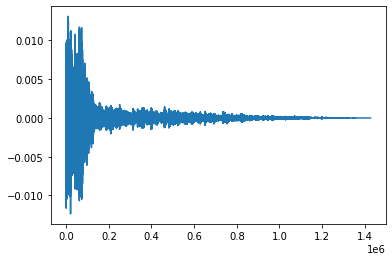

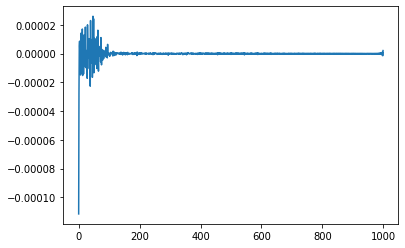

In [118]:
# Check large sample
from matplotlib import pyplot as plt


def normalize_sample(sample):
    array_of_samples = sample.get_array_of_samples()
    np_arr = np.array(array_of_samples)
    np_arr = np_arr.reshape(1, -1)
    return preprocessing.normalize(np_arr)

sample = AudioSegment.from_mp3(long_sample)
mono_samples = sample.split_to_mono()
normalized_sample = normalize_sample(mono_samples[0])[0]

print(len(normalized_sample))
plt.plot(normalized_sample)
plt.show()

resampled_sample = signal.resample(normalized_sample, 1000)

plt.plot(resampled_sample)
plt.show()

In [119]:
print(len(song_lounge_it))
print(len(song_tuesday_night))
print(len(song_kingtop))

126
43
74


In [120]:
full_songs = []
full_songs.extend(song_lounge_it)
full_songs.extend(song_tuesday_night)
full_songs.extend(song_kingtop)
len(full_songs)

243

In [121]:
# todo: Check smallest sample!!
samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    #resampled_sample = signal.resample(normalized_sample, 1000)
    samples.append(normalized_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    #resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, 1000)
    samples_sec_canal.append(normalized_sample_sec_canal)

In [122]:
min(map(len, samples))

16317

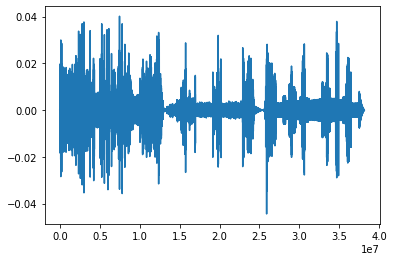

In [123]:
import itertools

plt.plot(list(itertools.chain.from_iterable(samples)))
plt.show()

In [124]:
len(samples)

243

In [125]:
# todo: Check smallest sample!!
samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    resampled_sample = signal.resample(normalized_sample, int(len(normalized_sample)/35))
    samples.append(resampled_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, int(len(normalized_sample)/35))
    samples_sec_canal.append(resampled_sample_sec_canal)

In [126]:
edge_size = min(map(len, samples))

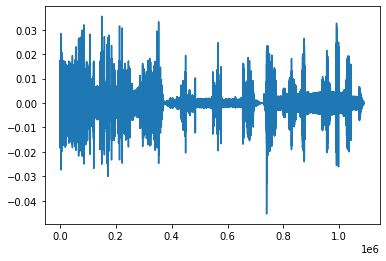

In [127]:
plt.plot(list(itertools.chain.from_iterable(samples)))
plt.show()

In [128]:
X_train = []
Y_train = []
for i in range(len(samples)-1):
    Y_train.append(True)
    first_half = list(samples[i][-edge_size:])
    last_half = list(samples[i + 1][:edge_size])
    X_train.append(first_half+last_half)
    if(i < len(samples)-2):
        Y_train.append(True)
        sec_last_half = list(samples[i + 2][:edge_size])
        X_train.append(first_half+sec_last_half)

In [129]:
min(map(len, X_train))

932

In [130]:
len(X_train)

483

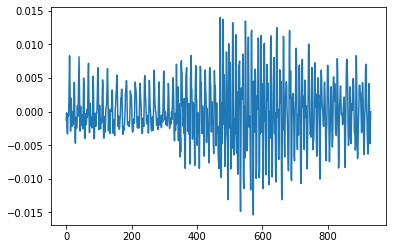

In [131]:
plt.plot(X_train[1])
plt.show()

In [132]:
from numpy import random

def get_strange_end_part(samples, current_index, max_len):
    x = random.randint(max_len-1)
    if (x != current_index+1) and (x != current_index+2):
        return list(samples[x][:edge_size])
    else:
        return get_strange_end_part(samples, current_index, max_len)


for i in range(len(samples)-1):
    first_half = list(samples[i][-edge_size:])
    last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+last_half)
    Y_train.append(False)
    sec_last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+sec_last_half)
    Y_train.append(False)

In [133]:
len(X_train)

967

In [134]:
min(map(len, X_train))

932

In [135]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 2*edge_size)
X_train.shape

(967, 932)

In [136]:
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1, 1)
Y_train.shape

(967, 1)

In [137]:
from keras.layers import Conv1D, LSTM, Flatten

model = Sequential()
model.add(Conv1D(filters=200, kernel_size=2, input_shape=(2*edge_size, 1)))
model.add(LSTM(400, return_sequences=True))
model.add(Dense(300))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 929, 200)          1000      
                                                                 
 lstm_4 (LSTM)               (None, 929, 400)          961600    
                                                                 
 dense_8 (Dense)             (None, 929, 300)          120300    
                                                                 
 flatten_4 (Flatten)         (None, 278700)            0         
                                                                 
 dense_9 (Dense)             (None, 1)                 278701    
                                                                 
Total params: 1,361,601
Trainable params: 1,361,601
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
31/31 [==============================] - 131s 4s/step - loss: 1.0631 - accuracy: 0.4871
Epoch 2/10
28/31 [==========================>...] - ETA: 12s - loss: 0.7498 - accuracy: 0.4688

KeyboardInterrupt: 

In [ ]:
example_x_train = X_train[-5]
example_x_train = example_x_train.reshape(1, 2*edge_size)
model.predict(example_x_train)